This notebook makes the figures for the liver cirrhosis case study.

Note: I wrote this before writing the `calculate_donor_ranks.py` script, so this notebook will make the same figures as in the final notebook but starting from different data. :)

In [1]:
import pandas as pd
import numpy as np
import feather

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set_palette(sns.color_palette('muted', n_colors=9)[4:])

In [2]:
ftidy = '../../data/clean/bn10.tidy_metabolomics.feather'
DF = feather.read_dataframe(ftidy)
DF.head()

,method,compound,mz,rt,hmdb_id,metabolite,sample,intensity,donor,sample_number
0,C18-neg,cmp.QI01,355.242367,7.757533,Internal Standard,PGE2-d4,0001-0163,289686.0,0001,0163
1,C18-neg,cmp.QI02,313.238162,9.830450,HMDB04705,12_13-diHOME,0001-0163,191459.0,0001,0163
2,C18-neg,cmp.QI03,313.238234,10.023333,HMDB04704,9_10-diHOME,0001-0163,196193.0,0001,0163
3,C18-neg,cmp.QI04,295.227428,11.289300,HMDB04667,13-HODE,0001-0163,82445.0,0001,0163
4,C18-neg,cmp.QI05,335.222620,11.003983,None,5_6 diHETE,0001-0163,32595.0,0001,0163


In [3]:
scfas = ['propionate', 'butyrate', 'isovalerate']
primary_bile = ['cholate', 'chenodeoxycholate']
secondary_bile = ['deoxycholate', 'lithocholate']

all_mlcls = scfas + primary_bile + secondary_bile

df = DF.query('metabolite == @all_mlcls')

In [4]:
# Some donors have multiple samples; take the mean abundance
df = (
    df.groupby(['donor', 'metabolite', ])
      ['intensity']
      .mean()
      .reset_index(name='mean_intensity')
)

# And log it
df['log_intensity'] = np.log10(df['mean_intensity'] + 1.0)

# Distribution of metabolite abundances in all donors

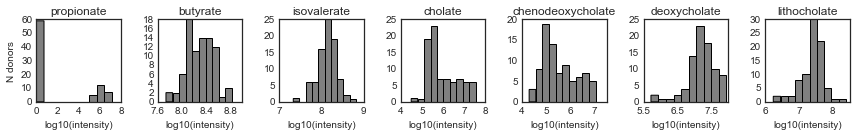

In [5]:
# For paper
fig, ax = plt.subplots(1, 7, figsize=(12, 2))

mlcls = scfas + primary_bile + secondary_bile
#colors = sns.color_palette('muted', n_colors=12)[4:12]

i = 0
for s in mlcls:
    subdf = df.query('metabolite == @s')
    
    ax[i].hist(subdf['log_intensity'], color='gray')
    ax[i].set_title(s)
    
    ax[i].set_xlabel('log10(intensity)')

    if i == 0:
        ax[i].set_ylabel('N donors')

    ax[i].set_xticks(ax[i].get_xticks()[::2])
    i += 1

fig.tight_layout()
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.distribution.png')

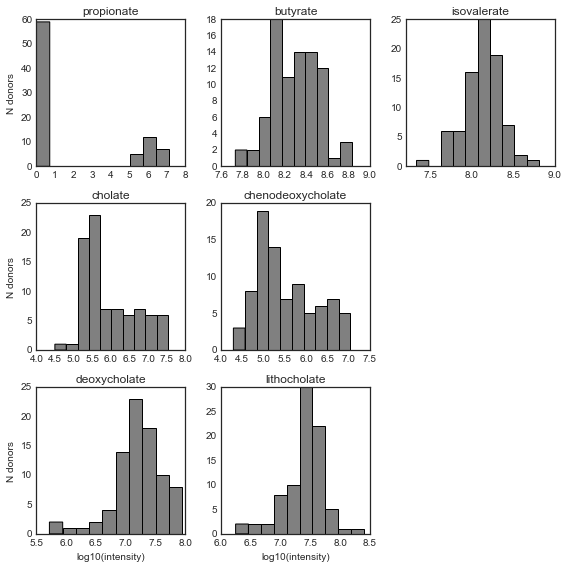

In [6]:
# For presentation slides
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
ax = ax.flatten()

i = 0
for s in scfas + primary_bile + secondary_bile:
    subdf = df.query('metabolite == @s')
    
    ax[i].hist(subdf['log_intensity'], color='gray')
    ax[i].set_title(s)
    
    if i in [6, 7]:
        ax[i].set_xlabel('log10(intensity)')

    if i in [0, 3, 6]:
        ax[i].set_ylabel('N donors')

    i += 1
    if s == "chenodeoxycholate":
        ax[i].set_axis_off()
        i += 1 

ax[i].set_axis_off()
fig.tight_layout()
fig.savefig('../../figures/presentation/fig3.scfas_bile_acid_conversion_bn10_donors.distribution.png')

# Calculate bile acid conversion ranks

In [7]:
# LCA + DCA / CDCA + CA
tmp = []
for d, subdf in df.groupby('donor'):
    total_primary = subdf.query('metabolite == @primary_bile').sum()['mean_intensity']
    total_secondary = subdf.query('metabolite == @secondary_bile').sum()['mean_intensity']
    tmp.append([d, total_primary, total_secondary])

bile_comp = pd.DataFrame(tmp, columns=['donor', 'total_primary', 'total_secondary'])
bile_comp['secondary_to_primary'] = bile_comp['total_secondary']/bile_comp['total_primary']

# LCA / CDCA
m2 = "lithocholate"
m1 = 'chenodeoxycholate'
col = m2 + '_' + m1
tmp_ratio = (df
     .query('(metabolite == @m2) | metabolite == @m1')
     .pivot(index='donor', columns='metabolite', values='mean_intensity')
)
tmp_ratio[col] = tmp_ratio[m2] / tmp_ratio[m1]
bile_comp = pd.merge(bile_comp, tmp_ratio, left_on='donor', right_index=True)

# DCA / CA
m2 = "deoxycholate"
m1 = 'cholate'
col = m2 + '_' + m1
tmp_ratio = (df
     .query('(metabolite == @m2) | metabolite == @m1')
     .pivot(index='donor', columns='metabolite', values='mean_intensity')
)
tmp_ratio[col] = tmp_ratio[m2] / tmp_ratio[m1]
bile_comp = pd.merge(bile_comp, tmp_ratio, left_on='donor', right_index=True)
bile_comp.head()

,donor,total_primary,total_secondary,secondary_to_primary,chenodeoxycholate,lithocholate,lithocholate_chenodeoxycholate,cholate,deoxycholate,deoxycholate_cholate
0,0001,334637.0,6.868328e+07,205.247133,184061.0,4.337812e+07,235.672511,150576.0,25305167.0,168.055779
1,0005,19465381.0,1.584497e+08,8.140079,5392116.0,8.933960e+07,16.568561,14073265.0,69110129.0,4.910739
2,0014,3960029.0,3.349853e+08,84.591640,2515267.0,2.465874e+08,98.036253,1444762.0,88397995.0,61.185161
3,0025,1351986.0,8.540477e+07,63.169860,330303.5,5.762863e+07,174.471764,1021682.5,27776132.0,27.186657
4,0026,7680949.6,8.166751e+07,10.632476,2374302.0,4.654574e+07,19.603970,5306647.6,35121766.2,6.618447


In [8]:
# Get back into tidy format for easier plotting
# Get back into tidy format
bile_tidy = bile_comp.melt(id_vars='donor', value_name='value')

In [9]:
# Order donors based on their total bile conversion
donor_order_ratio = bile_comp.sort_values(by='secondary_to_primary')['donor']

# And list the ratios we'll plot later
ratios = ['secondary_to_primary', 'lithocholate_chenodeoxycholate', 'deoxycholate_cholate']

# Rank donors based on SCFA amounts

In [10]:
# Convert to wide dataframe for easy ranking
df_wide = df.pivot(index='donor', columns='metabolite', values='mean_intensity')

# Convert ion intensities to ranks
# method=dense: like ‘min’, but rank always increases by 1 between groups
df_ranks = df_wide.rank(axis=0, method='dense')

# Re-melt into tidy form
tidy_ranks = pd.melt(df_ranks.reset_index(), id_vars='donor', value_name='rank')
tidy_ranks.head()

,donor,metabolite,rank
0,0001,butyrate,61.0
1,0005,butyrate,83.0
2,0014,butyrate,78.0
3,0025,butyrate,21.0
4,0026,butyrate,75.0


In [11]:
# Order donors by mean rank in the SCFAs
scfa_order = (
    tidy_ranks
        .query('metabolite == @scfas')
        .groupby('donor')
        .mean()
        .reset_index()
        .sort_values(by='rank')
        ['donor']
    )

# Make plots

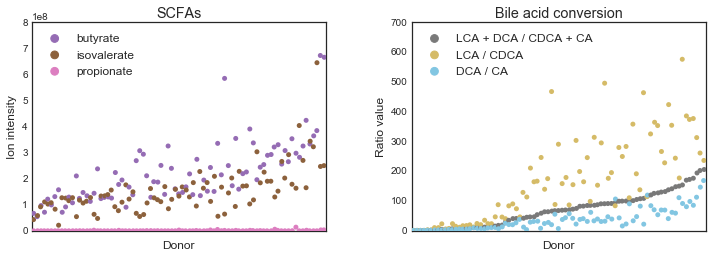

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.stripplot(
    data=df.query('metabolite == @scfas'), 
    x='donor', y='mean_intensity',
    order=scfa_order,
    hue='metabolite',
    ax=ax[0],
    palette=sns.color_palette('muted', n_colors=9)[4:])
ax[0].legend(loc='upper left')
ax[0].set_ylim([-100, None])
ax[0].set_ylabel('Ion intensity', fontsize='large')
ax[0].set_xlabel('Donor', fontsize='large')
ax[0].set_xticklabels('')
ax[0].set_title('SCFAs', fontsize='x-large')

## Bile acid conversion
sns.stripplot(
    data=bile_tidy.query('variable == @ratios'), 
    x='donor', y='value',
    order=donor_order_ratio,
    hue='variable',
    ax=ax[1],
    palette=sns.color_palette('muted', n_colors=10)[7:])

newlabels = ['LCA + DCA / CDCA + CA', 'LCA / CDCA', 'DCA / CA']
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles, newlabels,
             loc='upper left')
#          loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[1].set_ylim([-1, None])
ax[1].set_xticklabels('')
ax[1].set_xlabel('Donor', fontsize='large')
ax[1].set_ylabel('Ratio value', fontsize='large')
ax[1].set_title('Bile acid conversion', fontsize='x-large')

fig.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=5.0)
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.ranked.png')

# Plot rank in SCFAs vs. rank in bile acid conversion

Once I make the tidy data with each value and rank, I won't need to do any of the data wrangling below and can just plot directly.

In [23]:
scfa_ranked = (
    tidy_ranks
        .query('metabolite == @scfas')
        .groupby('donor')
        .mean()
        .reset_index()
        .sort_values(by='rank')
    )
scfa_ranked = scfa_ranked.rename(columns={'rank': 'avg_scfa_rank'})
scfa_ranked.head()

,donor,avg_scfa_rank
55,0118,1.666667
42,0104,3.000000
36,0093,7.666667
7,0032,10.000000
45,0107,10.333333


In [24]:
bile_comp['secondary_to_primary_rank'] = bile_comp['secondary_to_primary'].rank(method='dense')
bile_comp.head()

,donor,total_primary,total_secondary,secondary_to_primary,chenodeoxycholate,lithocholate,lithocholate_chenodeoxycholate,cholate,deoxycholate,deoxycholate_cholate,secondary_to_primary_rank
0,0001,334637.0,6.868328e+07,205.247133,184061.0,4.337812e+07,235.672511,150576.0,25305167.0,168.055779,83.0
1,0005,19465381.0,1.584497e+08,8.140079,5392116.0,8.933960e+07,16.568561,14073265.0,69110129.0,4.910739,16.0
2,0014,3960029.0,3.349853e+08,84.591640,2515267.0,2.465874e+08,98.036253,1444762.0,88397995.0,61.185161,51.0
3,0025,1351986.0,8.540477e+07,63.169860,330303.5,5.762863e+07,174.471764,1021682.5,27776132.0,27.186657,39.0
4,0026,7680949.6,8.166751e+07,10.632476,2374302.0,4.654574e+07,19.603970,5306647.6,35121766.2,6.618447,20.0


In [26]:
donors_ranked = pd.merge(scfa_ranked, bile_comp[['donor', 'secondary_to_primary_rank']])

## Plot

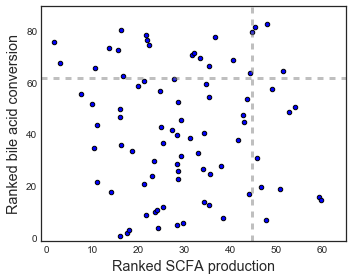

In [55]:
fig, ax = plt.subplots(figsize=(5, 4))

# Prepare cutoff values
percent_cutoff = 0.75
scfa_cutoff = percent_cutoff * donors_ranked['avg_scfa_rank'].max()
bile_cutoff = percent_cutoff * donors_ranked['secondary_to_primary_rank'].max()


ax.scatter(donors_ranked['avg_scfa_rank'], donors_ranked['secondary_to_primary_rank'],
           s=20)

ax.axvline(scfa_cutoff, alpha=0.5, linestyle='--', c='gray', linewidth=3)
ax.axhline(bile_cutoff, alpha=0.5, linestyle='--', c='gray', linewidth=3)

ax.set_xlim([-1, 65])
ax.set_ylim([-1, 90])

ax.set_xlabel('Ranked SCFA production', fontsize='x-large')
ax.set_ylabel('Ranked bile acid conversion', fontsize='x-large')

fig.tight_layout()
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.bile_acid_vs_scfa.png')